In [ ]:
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=url,
                                   fname='flower_photos.tgz',
                                   extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [ ]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

In [5]:
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

In [6]:
batch_size = 100
IMAGE_SHAPE = 150

In [14]:
def plot_images(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Horizontal Flip**

In [9]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMAGE_SHAPE,IMAGE_SHAPE))

Found 2935 images belonging to 5 classes.


In [10]:
train_data_gen[0][0][0][0][0]

array([0.90196085, 0.64705884, 0.5764706 ], dtype=float32)

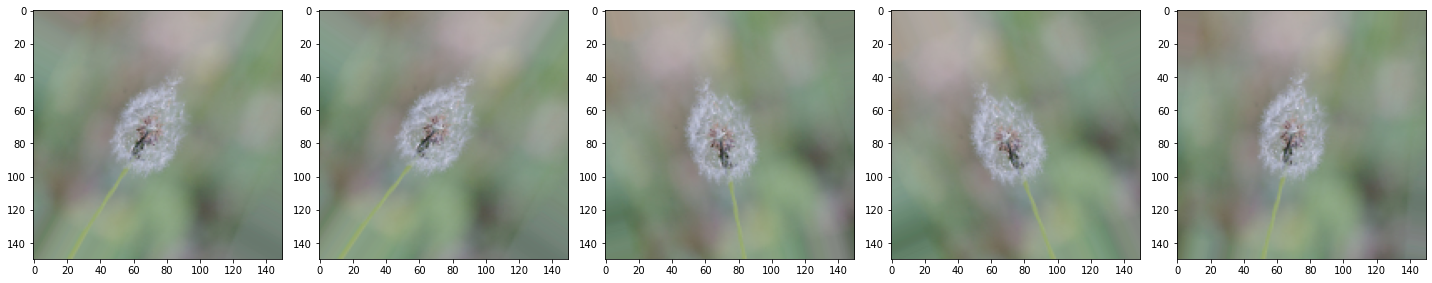

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

**Rotate**

In [16]:
image_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMAGE_SHAPE,IMAGE_SHAPE))

Found 2935 images belonging to 5 classes.


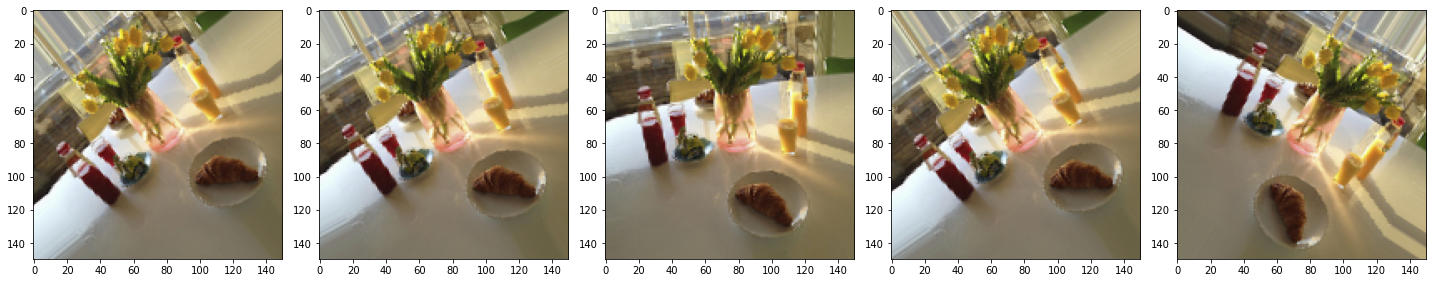

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

**Zoom**

In [18]:
image_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMAGE_SHAPE,IMAGE_SHAPE))

Found 2935 images belonging to 5 classes.


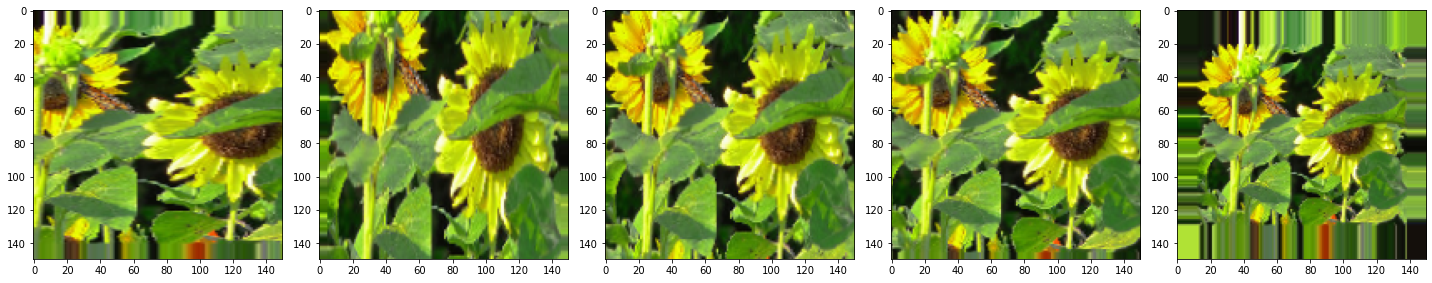

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

**Setting final training data with all augmentations**

In [20]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               rotation_range=45,
                               zoom_range=0.2,)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMAGE_SHAPE,IMAGE_SHAPE),
                                               class_mode='sparse')

Found 2935 images belonging to 5 classes.


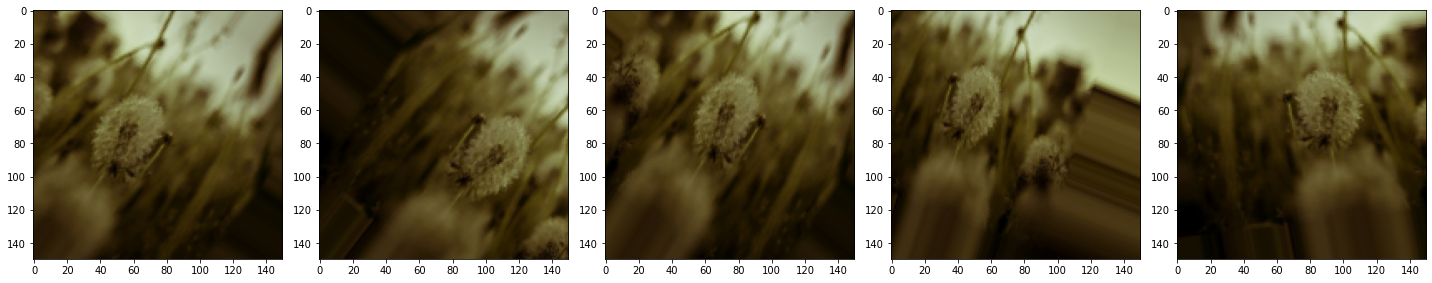

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

**Setting up validation data**

In [34]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                               directory=val_dir,
                                               shuffle=False,
                                               target_size=(IMAGE_SHAPE,IMAGE_SHAPE),
                                               class_mode='sparse'
                                              )

Found 735 images belonging to 5 classes.


**Build the model**

In [35]:
model = tf.keras.models.Sequential([
                                   tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
                                   tf.keras.layers.MaxPooling2D(2, 2),

                                   tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),

                                   tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),

                                   tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),

                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(512, activation='relu'),
                                   tf.keras.layers.Dense(5, activation='softmax')
])

In [36]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

**Train the model**

In [38]:
epochs = 80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n/float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps = int(np.ceil(val_data_gen.n/float(batch_size))),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 36s 1s/step - loss: 1.4226 - accuracy: 0.3557 - val_loss: 1.2154 - val_accuracy: 0.4517
Epoch 2/80
30/30 [==============================] - 22s 750ms/step - loss: 1.1843 - accuracy: 0.5060 - val_loss: 1.1584 - val_accuracy: 0.5374
Epoch 3/80
30/30 [==============================] - 22s 749ms/step - loss: 1.0835 - accuracy: 0.5547 - val_loss: 1.0182 - val_accuracy: 0.5769
Epoch 4/80
30/30 [==============================] - 22s 747ms/step - loss: 0.9924 - accuracy: 0.6044 - val_loss: 1.0195 - val_accuracy: 0.5986
Epoch 5/80
30/30 [==============================] - 23s 751ms/step - loss: 0.9491 - accuracy: 0.6327 - val_loss: 0.9441 - val_accuracy: 0.6299
Epoch 6/80
30/30 [==============================] - 22s 748ms/step - loss: 0.8990 - accuracy: 0.6518 - val_loss: 0.9572 - val_accuracy: 0.6190
Epoch 7/80
30/30 [==============================] - 22s 749ms/step - loss: 0.8701 - accuracy: 0.6562 - val_loss: 0.9049 - val_accuracy: 0.6490
Epoch 8/80
30

**Evaluation**

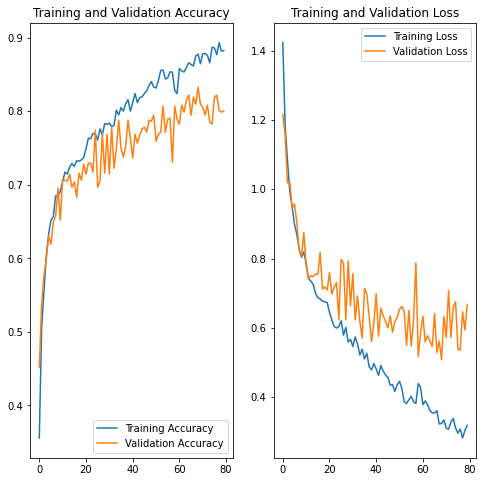

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()